<a href="https://colab.research.google.com/github/yishairasowsky/Sefaria-Project/blob/master/ML/topic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd
import shutil
# shutil.move("/moses-sources.csv", "/content/drive/My Drive/Colab Datasets/moses-sources.csv")
# shutil.move("/abraham-sources.csv", "/content/drive/My Drive/Colab Datasets/abraham-sources.csv")
# encoding_type = "latin-1"
encoding_type = "utf-8"

prayer_df = pd.read_csv('/content/drive/My Drive/Colab Datasets/prayer-sources.csv', encoding=encoding_type)
prayer_df['topic'] = 'prayer'

# not_prayer_df = pd.read_csv('/content/drive/My Drive/Colab Datasets/not-prayer-sources.csv', encoding=encoding_type)
# not_prayer_df['topic'] = 'not_prayer'

moses_df = pd.read_csv('/content/drive/My Drive/Colab Datasets/moses-sources.csv', encoding=encoding_type)
moses_df['topic'] = 'moses'

abraham_df = pd.read_csv('/content/drive/My Drive/Colab Datasets/abraham-sources.csv', encoding=encoding_type)
abraham_df['topic'] = 'abraham'

df = pd.concat([prayer_df,
                    # not_prayer_df,
                    moses_df,
                    abraham_df])

# big_df = pd.read_csv('/content/drive/My Drive/Colab Datasets/yishai_data.csv',encoding="utf-8")
# big_df['En'] = big_df['En'].astype(str)
# df = df.reset_index(drop=True)




In [97]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2434 entries, 0 to 646
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Ref     2434 non-null   object
 1   En      1341 non-null   object
 2   He      2429 non-null   object
 3   topic   2434 non-null   object
dtypes: object(4)
memory usage: 95.1+ KB


In [98]:
# print(big_df.info)
# big_df.shape
# small_df = big_df[:1000]
# df = big_df
df.sample(13)

,Ref,En,He,topic
509,Berakhot 4b:17-20,This statement extolling the significance of t...,מַאי טַעְמָא? אִילֵּימָא מִשּׁוּם דְּאָתְיָא ב...,prayer
179,Gevurot Hashem 16:4,NaN,ותהר האשה ותלד בן וגו' והא הות מעברא ביה מעיקר...,moses
344,Radak on Genesis 16:14:2,"הנה בין קדש ובין ברד, The Torah gives an indic...","הנה בין קדש ובין ברד, נתן סימן לבאר הזה אנה הו...",abraham
441,Netzach Yisrael 53:1-3,NaN,כבר בארנו בחבור גבורות ה' כי לא היה דבר אחד בג...,moses
240,"Alshich on Torah, Exodus 6:13:6",NaN,אמנם הנה כתבנו למעלה כי משה היה המתוקן לגאולה ...,moses
604,II Kings 4:9-11,"And she said unto her husband: ‘Behold now, I ...",וַתֹּ֙אמֶר֙ אֶל־אִישָׁ֔הּ הִנֵּה־נָ֣א יָדַ֔עְת...,abraham
291,Or HaChaim on Numbers 14:24:1-2,"ועבדי כלב , ""and My servant Caleb, etc."" Why d...",ועבדי כלב עקב וגו' . צריך לדעת למה לא הזכיר אל...,prayer
413,"Shem MiShmuel, Vayakhel 10:14",NaN,ונראה דהנה הערעור על משה בודאי איננו על מה שנט...,moses
711,Ibn Ezra on Exodus 2:3:2,NaN,ותחמרה . נחה ה''א כה''א ויקרא לה נובח בשמו. וז...,moses
282,"Shenei Luchot HaBerit, Toldot Adam, Introducti...",NaN,וגם העבודה שבלבנו היא התפלה במקום קרבן המקרב ו...,prayer


In [99]:
# df['Topics'] = df['Topics'].astype(str)

# print("\nNulls before dropping:",df.isnull().sum()[0])
# df.dropna(how = 'any', inplace=True)
# print("Nulls after dropping:",df.isnull().sum()[0])

print("Before dropping nulls",df.shape)
# df.dropna(how = 'any', inplace=True)
df.dropna(inplace=True)
# df.drop_duplicates(inplace=True)
print("After dropping nulls",df.shape)

print("Before dropping duplicates",df.shape)
df.drop_duplicates(inplace=True)
print("After dropping duplicates",df.shape)

# df['En'] = df['En'].astype(str)

df = df.reset_index(drop=True)
# all_prayer_df.sample(5)# null_filter = df["En"] != ""
# df = df[null_filter]
df.sample(3)


Before dropping nulls (2434, 4)
After dropping nulls (1341, 4)
Before dropping duplicates (1341, 4)
After dropping duplicates (1307, 4)


,Ref,En,He,topic
655,Bekhorot 44a:15-16,"GEMARA: Rav says: Moses, our teacher, was ten ...",גמ׳ אמר רב משה רבינו עשר אמות היה שנאמר (שמות ...,moses
853,Exodus 16:5-12,And it shall come to pass on the sixth day tha...,וְהָיָה֙ בַּיּ֣וֹם הַשִּׁשִּׁ֔י וְהֵכִ֖ינוּ אֵ...,moses
428,Isaiah 45:7,"I form the light, and create darkness; I make ...",יוֹצֵ֥ר אוֹר֙ וּבוֹרֵ֣א חֹ֔שֶׁךְ עֹשֶׂ֥ה שָׁל֖...,prayer


In [100]:
df = df[['En','topic']]
# df['topic'].str.split()
df = df.join(df.pop('topic').str.get_dummies())
# df = df.join(df.pop('topic').str.get_dummies(' '))
df.sample(9)
# df = small_df[['En','Topics']]
# df['Topics'].str.split()
# df = df.join(df.pop('Topics').str.get_dummies(' '))
# df.head(3)

,En,abraham,moses,prayer
745,"וראית את אחורי , ""you will see My back, etc."" ...",0,1,0
1173,"And Abram went up out of Egypt, he, and his wi...",1,0,0
875,"And it came to pass, when the ark set forward,...",0,1,0
64,"And Abraham drew near, and said: ‘Will You ind...",0,0,1
448,From what time may one recite the Shema in the...,0,0,1
459,The sacrifice is slaughtered for the sake of s...,0,0,1
547,During the prayer leader's repetition: We shal...,0,0,1
278,The Gemara asks: Who is the tanna who taught t...,0,0,1
202,There is a great difficulty in connection with...,0,0,1


In [0]:
# df.columns

In [101]:
# df["En"].iloc[[67]]
# df.iloc[[67]]
# del df['not_prayer']
df.sample(5)

,En,abraham,moses,prayer
56,The Gemara asks: And with regard to the other ...,0,0,1
1130,"והיה שמך אברהם, “and your name will be Avraham...",1,0,0
971,And he recites at the end of all of these six ...,1,0,0
630,"Alternatively, G'd implied that all the people...",0,1,0
853,And it shall come to pass on the sixth day tha...,0,1,0


In [103]:
# topics = df.columns
topics = list(df.columns)

# topics[:5]

# type(list(df.columns))
# topics[:5]

del topics[0]

# topics = ['prayer','moses','torah','god','egypt']

# topics[:10]
# type(topics )

hits = {topic:df[topic].sum() for topic in topics}
# hits['parah-adumah']
from collections import Counter
counter = Counter(hits)
for topic, num in counter.most_common(10):
     print( '%s: %i' % (topic, num))


prayer: 553
moses: 394
abraham: 360


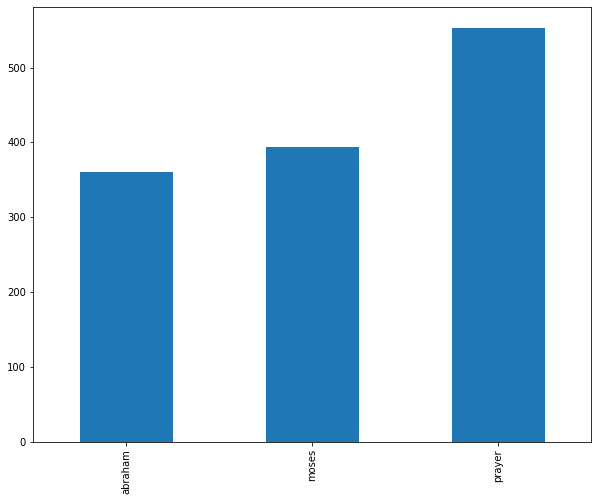

In [104]:
labels = df[topics]
labels.head(3)

import matplotlib as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

labels.sum(axis=0).plot.bar()

# from sklearn.preprocessing import MultiLabelBinarizer
# mlb = MultiLabelBinarizer()
# mlb.fit(df['Topics'])
# mlb.transform(df['Topics'])
# df.head()


In [0]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [0]:
import re

X = []
sentences = list(df["En"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = labels.values

In [108]:
X[:10]

['Another of Abba Binyamin statements with regard to the laws of prayer was taught in baraita Abba Binyamin says If two people enter synagogue outside of the city in order to pray and one began praying before the other and did not wait for the other person to complete his prayer and left him alone in the synagogue his prayer is thrown back in his face Because he left the other person alone and caused him to be distracted during his prayer his own prayer is thrown back in his face as it is stated You who throw your soul in your face for your sake will the earth be forsaken The Rock will be moved from its place Job This verse indicates that one who left the other person alone effectively causes his soul as prayer is the outpouring of the soul before God to be thrown in his face God says to that person For your sake do you think because you left the earth will be forsaken that God will leave the world and the prayer of the other person will go unheard Not only that but it causes the Divin

In [110]:
y[:10]

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [112]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


Using TensorFlow backend.


In [113]:
for matrix_name, matrix in {
    'X_train':X_train, 
    'y_train':y_train, 
    'X_test':X_test, 
    'y_test':y_test
    }.items():
      print(matrix_name, matrix.shape)

X_train (1045, 200)
y_train (1045, 3)
X_test (262, 200)
y_test (262, 3)


In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/My Drive/Colab Datasets/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [0]:
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, LSTM
from keras.layers.core import Activation, Dropout, Dense
from keras.models import Model

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(3, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [116]:
print(model.summary())


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          1128100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 1,245,735
Trainable params: 117,635
Non-trainable params: 1,128,100
_________________________________________________________________
None


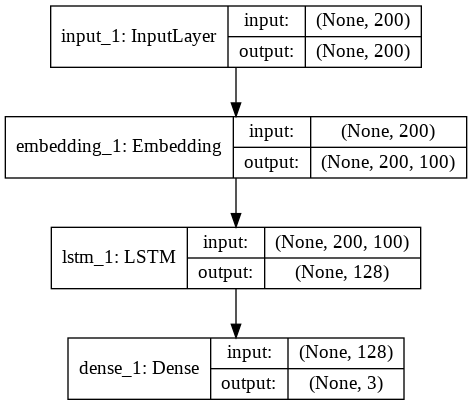

In [117]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)


In [118]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)


Train on 836 samples, validate on 209 samples
Epoch 1/5
836/836 [==============================] - 6s 8ms/step - loss: 0.6763 - acc: 0.6515 - val_loss: 0.6675 - val_acc: 0.6667
Epoch 2/5
836/836 [==============================] - 6s 7ms/step - loss: 0.6570 - acc: 0.6667 - val_loss: 0.6500 - val_acc: 0.6683
Epoch 3/5
836/836 [==============================] - 6s 7ms/step - loss: 0.6246 - acc: 0.6726 - val_loss: 0.6408 - val_acc: 0.6715
Epoch 4/5
836/836 [==============================] - 6s 7ms/step - loss: 0.6140 - acc: 0.6762 - val_loss: 0.6294 - val_acc: 0.6794
Epoch 5/5
836/836 [==============================] - 6s 7ms/step - loss: 0.6059 - acc: 0.6894 - val_loss: 0.6211 - val_acc: 0.6810


In [0]:
# prayer_df.sample(3)

In [0]:
# prayer_df['is_prayer'] = 'yes'
# prayer_df = prayer_df[['En','is_prayer']]

# prayer_df.tail(3)

In [0]:
# not_prayer_df.sample(3)

In [0]:
# not_prayer_df['is_prayer'] = 'no'
# not_prayer_df = not_prayer_df[['En','is_prayer']]
# not_prayer_df.sample(3)

In [0]:
# all_prayer_frames = [prayer_df, not_prayer_df]
# all_prayer_df = pd.concat(all_prayer_frames)
# all_prayer_df.reset_index(inplace=True)
# all_prayer_df=all_prayer_df.rename(columns = {'En':'english_text'})


# # all_prayer_df.style.set_properties({'align': 'right'})

# # all_prayer_df.tail(3)
# all_prayer_df.sample(5)
big_df.sample(5)
# # all_prayer_df.loc[[345]]

,index,english_text,is_prayer
273,273,"'××ª×§×¨× ×©× ×, the meaning of the words ...",yes
83,83,And Moses and Aaron went out from Pharaoh; and...,yes
1376,324,"And furthermore, if it should enter your mind ...",no
343,343,The Gemara relates another incident involving ...,yes
569,569,NaN,yes


In [0]:
del all_prayer_df['index']

all_prayer_df.sample(3)

,english_text,is_prayer
1980,NaN,no
217,NaN,yes
1342,MISHNA: All foods that became ritually impure ...,no


In [0]:
print("Before dropping duplicates",all_prayer_df.shape)
all_prayer_df.drop_duplicates(inplace=True)
print("After dropping duplicates",all_prayer_df.shape)

print("\nNulls before dropping:",all_prayer_df.isnull().sum()[0])
all_prayer_df.dropna(inplace=True)
print("Nulls after dropping:",all_prayer_df.isnull().sum()[0])

# all_prayer_df.isnull().sum()
# all_prayer_df.sample(5)

Before dropping duplicates (2103, 2)
After dropping duplicates (1223, 2)

Nulls before dropping: 2
Nulls after dropping: 0


In [0]:
shape = all_prayer_df.shape
print(f"{shape[0]} rows and {shape[1]} columns")

1221 rows and 2 columns


In [0]:
all_prayer_df['is_prayer'] = all_prayer_df['is_prayer'].map({'no': 0, 'yes': 1})
all_prayer_df.sample(5)

,english_text,is_prayer
1340,"The Jewish neighbors came and spoke to Abaye, ...",0
996,The Gemara asks: Is that to say that one who r...,1
281,"And furthermore, Rabbi Yosei said: May my port...",1
1638,"When Jehoiakim came along and reigned, he said...",0
15,On the topic of prayers recited while travelin...,1


In [0]:
print('Prayer:', (all_prayer_df.is_prayer.values == 1).sum())
print('Not prayer:', (all_prayer_df.is_prayer.values == 0).sum())

Prayer: 553
Not prayer: 668


In [0]:
import re
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')

# BAD_SYMBOLS_RE = re.compile('[^a-z #+_]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

# BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_ \b\d+\b]')
STOPWORDS = set(stopwords.words('english'))

def process_text(text):
    #  text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

# whitelist = set('abcdefghijklmnopqrstuvwxyz ZXCVBNMASDFGHJKLQWERTYUIOP')
# genres['movie_id'] = genres['movie_id'].astype(str)

# def process_text(text):
#     '''
#     1. Keep only letters and spaces
#     2. Remove stopwords
#     3. Return str of clean text words
#     '''
#     #1
#     chars_str = ''.join(filter(whitelist.__contains__, text))
#     #2
#     clean_words = [word.lower() for word in chars_str.split() if word.lower() not in stopwords.words('english')]
#     #3
#     return ' '.join(clean_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
sample_text = '''aBC.!@#$%^&    c*(בחתו ‎‎‎ או‎ בקרחתו — une...
233 the gns: ac ...
1041    7. a pien p'''
process_text(sample_text)

'abc # c une233 gns ac 1041 7 pien p'

In [0]:
all_prayer_df.sample(5)

,english_text,is_prayer
1730,××¢×©××ª ××¨ ××× ×××¡××¨×ª× AND THOU...,0
528,JOY: The second [branch of love of G-d] is joy...,1
1465,(1) Sins between man and G-d only. For example...,0
1066,"But if its name must be á¸¥agav , one might ha...",0
1375,And the women said unto Naomi: âBlessed be t...,0


In [0]:
processed_df = all_prayer_df
processed_df['english_text'] = processed_df['english_text'].apply(process_text)
processed_df.head(5)

,english_text,is_prayer
0,another abba binyamins statements regard laws ...,1
1,taught baraita abba binyamin said ones prayer ...,1
2,additionally ravin bar rav adda said rabbi yit...,1
3,similarly taught baraita rabbi yishmael ben el...,1
4,meaning written let prayer unto lord time favo...,1


In [0]:
# all_prayer_df['En'] = all_prayer_df['En'].apply(stemming)
# all_prayer_df.head()
stemmed_df = processed_df
stemmed_df['english_text'] = stemmed_df['english_text'].apply(stemming)
stemmed_df.head()

,english_text,is_prayer
0,anoth abba binyamin statement regard law praye...,1
1,taught baraita abba binyamin said one prayer f...,1
2,addit ravin bar rav adda said rabbi yitzak sai...,1
3,similar taught baraita rabbi yishmael ben elis...,1
4,mean written let prayer unto lord time favor g...,1


In [0]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# prayer_words = ' '.join(list(all_prayer_df[stemmed_df['is_prayer'] == 1]['En']))
# prayer_wc = WordCloud(width = 512,height = 512).generate(prayer_words)
# plt.figure(figsize = (10, 8), facecolor = 'k')
# plt.imshow(prayer_wc)
# plt.axis('off')
# plt.tight_layout(pad = 0)
# plt.show()

In [0]:
# not_prayer_words = ' '.join(list(all_prayer_df[all_prayer_df['is_prayer'] == 0]['En']))
# not_prayer_wc = WordCloud(width = 512,height = 512).generate(not_prayer_words)
# plt.figure(figsize = (10, 8), facecolor = 'k')
# plt.imshow(not_prayer_wc)
# plt.axis('off')
# plt.tight_layout(pad = 0)
# plt.show()

In [0]:
df = stemmed_df
df.head()

,english_text,is_prayer
0,anoth abba binyamin statement regard law praye...,1
1,taught baraita abba binyamin said one prayer f...,1
2,addit ravin bar rav adda said rabbi yitzak sai...,1
3,similar taught baraita rabbi yishmael ben elis...,1
4,mean written let prayer unto lord time favor g...,1


In [0]:
from keras.preprocessing.sequence import pad_sequences
X = df['english_text']
# X = tokenizer.texts_to_sequences(df['english_text'].values)
# X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1221,)


In [0]:
Y = pd.get_dummies(df['is_prayer']).values
print('Shape of label tensor:', Y.shape)


Shape of label tensor: (1221, 2)


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(1098,) (1098, 2)
(123,) (123, 2)


In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', oov_token="<OOV>", lower=True)
tokenizer.fit_on_texts(X_train)
# tokenizer.fit_on_texts(df['english_text'].values)


In [0]:

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
# X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
# print('Shape of data tensor:', X.shape)
vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)


AttributeError: ignored

In [0]:


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))



In [0]:
"""
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
"""

In [0]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers.core import Dense, SpatialDropout1D
# from tensorflow.python.keras.layers.recurrent import LSTM
from keras.layers.recurrent import LSTM

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='sigmoid'))
# model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
batch_size = 64

# history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


In [0]:
# X = df.english_text
# y = df.is_prayer
# print(f"Totals: {X.shape} / {y.shape}")

# from sklearn.model_selection import train_test_split

# # train, test = train_test_split(movies, random_state=42, test_size=0.30, shuffle=True)

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=56, test_size=0.20, shuffle=True)

# print(f"\nTrain: {X_train.shape} / {y_train.shape}")

# print(f"\nTest: {X_test.shape} / {y_test.shape}")

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

history = model.fit(X_train, Y_train, 
                    epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

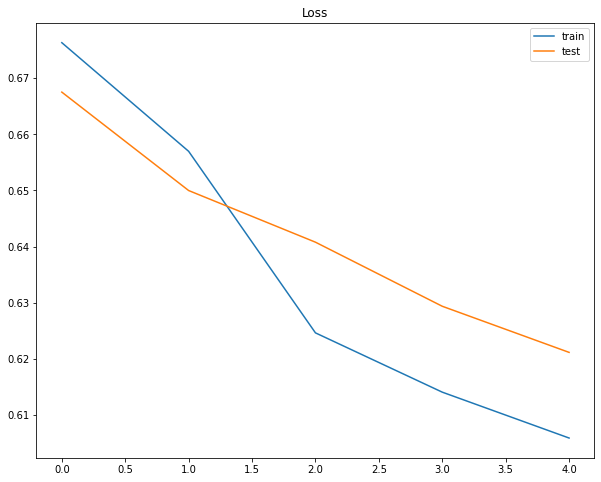

In [119]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();


In [120]:
model.metrics_names


['loss', 'acc']

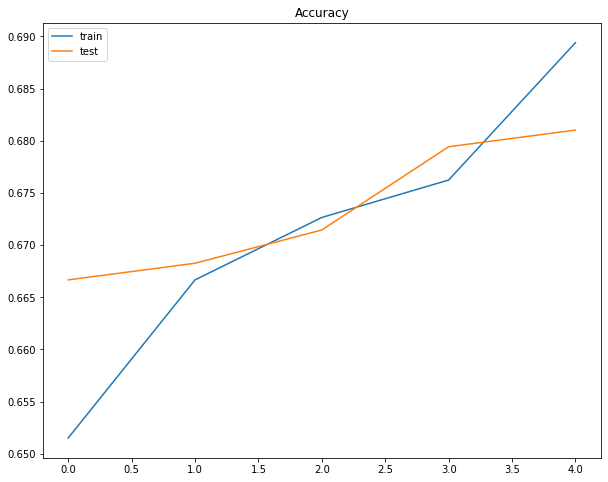

In [122]:
plt.title('Accuracy')
# plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['acc'], label='train')
# plt.plot(history.history['val_accuracy'], label='test')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();


In [127]:
new_complaint = ['I am a abraham to open up .']
# new_complaint = ['I am a pray pray pray pray to open up .']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=maxlen)
# padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['moses','abraham','prayer']
print(pred, labels[np.argmax(pred)])

[[0.25726274 0.37398458 0.41063678]] prayer


In [0]:
# # Convert a collection of text documents to a matrix of token counts

# from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer

# # vectorizer = CountVectorizer(analyzer=process_text)
# # vectorizer = CountVectorizer(ngram_range=(2, 4))
# # vectorizer = HashingVectorizer(ngram_range=(2, 4),alternate_sign=False)
# vectorizer = TfidfVectorizer(
#     # strip_accents='unicode', 
#     # analyzer='word', 
#     ngram_range=(1,3), 
#     # norm='l2', 
#     # max_features = 15000
#     # max_features = 12000
#     max_features = 10000
#     # max_features = 8000
#     # max_features = 5000
#     )

# # vectorizer = TfidfVectorizer(ngram_range=(2, 4))
# # vectorizer.fit(X_train)
# # vectorizer.get_feature_names()


In [0]:
# print("Shape of document term matrix")

# # X_train_dtm = vectorizer.transform(X_train)
# X_train_dtm = vectorizer.fit_transform(X_train)
# print(f"Train: {X_train_dtm.shape}")

# # prayer_bag_of_words = vectorizer.fit_transform(all_prayer_df['En'])
# X_test_dtm = vectorizer.transform(X_test)
# print(f"Test: {X_test_dtm.shape}")


In [0]:

# print(vectorizer.get_feature_names())


In [0]:
# from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, ComplementNB

# classifier = MultinomialNB()
# # classifier = ComplementNB()

# # for Gaussian need array format
# # X_train = X_train.toarray()
# # X_test = X_test.toarray()
# # classifier = GaussianNB()
# # classifier = BernoulliNB()

# %time classifier.fit(X_train_dtm, y_train)
# y_pred_class = classifier.predict(X_test_dtm)
# from sklearn import metrics

# print(f"\nBreakdown:\n{y_test.value_counts()[0]} non-prayer (0), and\n{y_test.value_counts()[1]} prayer (1)")

# null_accuracy = y_test.value_counts().head(1) / len(y_test)
# print(f'\nNull accuracy: {null_accuracy[0]}')

# non_prayer_passages = y_test.value_counts()[0]
# prayer_passages = y_test.value_counts()[1]
# print('Manual null accuracy:',(prayer_passages / (prayer_passages + non_prayer_passages)))

# print('\nAccuracy:',round(metrics.accuracy_score(y_test, y_pred_class),2))
# print('Precision:',round(metrics.precision_score(y_test, y_pred_class),2))
# print('Recall:',round(metrics.recall_score(y_test, y_pred_class),2))
# print('F1 score:',round(metrics.f1_score(y_test, y_pred_class),2))

# print("\nConfusion Matrix:")
# print(metrics.confusion_matrix(y_test, y_pred_class))


In [0]:

# from sklearn.model_selection import cross_val_score
# # clf = svm.SVC(kernel='linear', C=1)
# scores = cross_val_score(classifier, X, y, cv=5)
# scores


In [0]:
# TP = X_test[y_pred_class + y_test == 2]
# TN = X_test[y_pred_class + y_test == 0]
# FP = X_test[y_pred_class > y_test]
# FN = X_test[y_pred_class < y_test]

# pd.options.display.max_colwidth = 100

# # pd.style.set_properties(**{'text-align': 'left'})

# # print("\n*** TP ***")
# # print(TP.sample(5))
# # print("\n*** TN ***")
# # print(TN.sample(5))
# print("*** False Positives: Actually NOT prayer, but misclassified as prayer ***\n")
# print(FP.sample(10))
# print("\n\n*** False Negatives: Actually prayer, but misclassified as NOT prayer ***\n")
# print(FN.sample(10))

In [0]:
# FP.to_csv('FP', sep='\t', encoding='utf-8')
# FN.to_csv('FN', sep='\t', encoding='utf-8')
